# Conversion de grille du fichier de référence aux fichiers de sortie

In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import os
import xesmf as xe
import matplotlib.pyplot as plt

/srv/conda/envs/notebook/lib/python3.12/site-packages/esmpy/interface/loadESMF.py:94: VersionWarning: ESMF installation version 8.8.0, ESMPy version 8.8.0b0
  warnings.warn("ESMF installation version {}, ESMPy version {}".format(


In [2]:
# reference grid
path = "grid/"
file = "nhsce_mon.v01r01_19661004_20250303_1.0x1.0.nc"
ref_grid = xr.open_dataset(os.path.join(path, file))

In [3]:
# good areas 
path = "grid/"
file = "area.nc"
area = xr.open_dataset(os.path.join(path, file))

In [4]:
print(ref_grid.variables)

Frozen({'land': <xarray.Variable (lat: 180, lon: 360)> Size: 259kB
[64800 values with dtype=float32]
Attributes:
    standard_name:  land_binary_mask
    long_name:      land water mask
    cell_methods:   time: mean
    flag_values:    [0 1]
    flag_meanings:  water land, 'lat': <xarray.IndexVariable 'lat' (lat: 180)> Size: 1kB
array([-89.5, -88.5, -87.5, -86.5, -85.5, -84.5, -83.5, -82.5, -81.5, -80.5,
       -79.5, -78.5, -77.5, -76.5, -75.5, -74.5, -73.5, -72.5, -71.5, -70.5,
       -69.5, -68.5, -67.5, -66.5, -65.5, -64.5, -63.5, -62.5, -61.5, -60.5,
       -59.5, -58.5, -57.5, -56.5, -55.5, -54.5, -53.5, -52.5, -51.5, -50.5,
       -49.5, -48.5, -47.5, -46.5, -45.5, -44.5, -43.5, -42.5, -41.5, -40.5,
       -39.5, -38.5, -37.5, -36.5, -35.5, -34.5, -33.5, -32.5, -31.5, -30.5,
       -29.5, -28.5, -27.5, -26.5, -25.5, -24.5, -23.5, -22.5, -21.5, -20.5,
       -19.5, -18.5, -17.5, -16.5, -15.5, -14.5, -13.5, -12.5, -11.5, -10.5,
        -9.5,  -8.5,  -7.5,  -6.5,  -5.5,  -4.5,  -3

In [8]:
area["cell_area"]

<xarray.DataArray 'cell_area' (lat: 180, lon: 360)> Size: 518kB
[64800 values with dtype=float64]
Coordinates:
  * lon      (lon) float64 3kB -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * lat      (lat) float64 1kB -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
Attributes:
    standard_name:  area
    long_name:      area of grid cell
    units:          m2

In [6]:
# selection of the reference period
ref_grid = ref_grid.sel(time=slice("1995", "2014"))

## Reference snow expansion by month

In [7]:
snow_cover = ref_grid["snow_cover_extent"]

snow_cover = snow_cover.groupby("time.month").mean(dim="time")

In [9]:
ref_grid["snow_cover_extent"]

<xarray.DataArray 'snow_cover_extent' (time: 240, lat: 180, lon: 360)> Size: 62MB
[15552000 values with dtype=float32]
Coordinates:
  * lat      (lat) float64 1kB -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 3kB -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * time     (time) datetime64[ns] 2kB 1995-01-16 1995-02-16 ... 2014-12-15
Attributes:
    standard_name:  surface_snow_binary_mask
    long_name:      NOAA/NCEI Climate Data Record of snow cover extent
    cell_methods:   time: mean
    flag_values:    [0 1]
    flag_meanings:  no_snow snow_covered

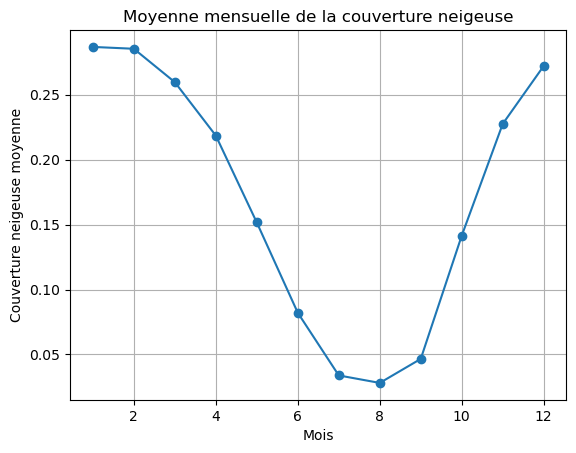

In [8]:
monthly_mean = snow_cover.mean(dim=("lat", "lon"))

plt.plot(range(1, 13), monthly_mean, marker="o")
plt.xlabel("Mois")
plt.ylabel("Couverture neigeuse moyenne")
plt.title("Moyenne mensuelle de la couverture neigeuse")
plt.grid()
plt.show()

In [9]:
cell_area = area["cell_area"]

snow_cover_km2 = (snow_cover * (cell_area * 1e-6) ).groupby(snow_cover["month"]).sum(dim=["lat", "lon"], skipna=True)

print(snow_cover_km2)
print(snow_cover_km2.shape)

<xarray.DataArray (month: 12)> Size: 96B
array([47527339.11645807, 47170685.33438697, 41034269.29181223,
       32014146.33675294, 19553457.31518154,  9003870.52668834,
        3134122.09805531,  2460193.82986189,  4226952.56887794,
       17861365.62524626, 34152238.95970662, 44012796.3253699 ])
Coordinates:
  * month    (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
(12,)


In [10]:
area = cell_area.sum(dim=["lat", "lon"], skipna=True)
print(area)

<xarray.DataArray 'cell_area' ()> Size: 8B
array(5.10064472e+14)


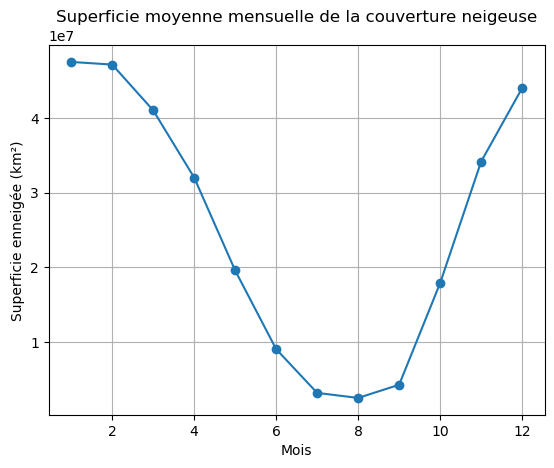

In [11]:
plt.plot(range(1, 13), snow_cover_km2, marker="o")
plt.xlabel("Mois")
plt.ylabel("Superficie enneigée (km²)")
plt.title("Superficie moyenne mensuelle de la couverture neigeuse")
plt.grid()
plt.show()

## Reprojection

In [15]:
grille_cible = {
    "lon":ref_grid["lon"],
    "lat":ref_grid["lat"]
}

In [34]:
path2 = "SnowWarming/"

models = [
    "BCC-CSM2-MR", "CanESM5", "CanESM5-CanOE", "CESM2", "CESM2-WACCM", "CIESM",
    "CNRM-CM6-1", "CNRM-CM6-1-HR", "CNRM-ESM2-1", "EC-Earth3", "EC-Earth3-Veg",
    "FGOALS-f3-L", "FGOALS-g3", "GFDL-CM4", "GISS-E2-1-G", "HadGEM3-GC31-LL",
    "IPSL-CM6A-LR", "MIROC-ES2L", "MIROC6", "MPI-ESM1-2-HR", "MPI-ESM1-2-LR",
    "MRI-ESM2-0", "NorESM2-LM", "NorESM2-MM", "UKESM1-0-LL"
]

datasets = {}

for model in models:
    file_path = os.path.join(path2, f"SnowWarming_{model}_historical+ssp585.nc")
    datasets[model] = xr.open_dataset(file_path)

ref_grid = ref_grid
regridders = {model: xe.Regridder(ds, ref_grid, "bilinear", periodic=True) for model, ds in datasets.items()}
datasets_regridded = {model: regridders[model](ds) for model, ds in datasets.items()}

output_dir = "interp_models"
os.makedirs(output_dir, exist_ok=True)

for model, ds in datasets_regridded.items():
    output_path = os.path.join(output_dir, f"{model}_reprojete.nc")
    ds.to_netcdf(output_path)